# [Practical Statistics for Data Scientists](https://www.oreilly.com/library/view/practical-statistics-for/9781491952955/)
by Peter Bruce, Andrew Bruce, & Peter Gedeck

Initialize python environment and import dataset

In [53]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)

In [3]:
df = pd.read_csv("data/nba_all_elo.csv", parse_dates=[5],
    dtype={
        "lg_id": "category",
        "_iscopy": "category",
        "seasongame": "category",
        "is_playoffs": "category",
        "team_id": "category",
        "fran_id": "category",
        "opp_id": "category",
        "opp_fran": "category",
        "game_location": "category",
        "game_result": "category"
    }
)
df.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,1946-11-01,1,0,TRH,Huskies,66,1300.00,1293.28,40.29,NYK,Knicks,68,1300.00,1306.72,H,L,0.64,NaN
1,1,194611010TRH,NBA,1,1947,1946-11-01,1,0,NYK,Knicks,68,1300.00,1306.72,41.71,TRH,Huskies,66,1300.00,1293.28,A,W,0.36,NaN
2,2,194611020CHS,NBA,0,1947,1946-11-02,1,0,CHS,Stags,63,1300.00,1309.65,42.01,NYK,Knicks,47,1306.72,1297.07,H,W,0.63,NaN
3,2,194611020CHS,NBA,1,1947,1946-11-02,2,0,NYK,Knicks,47,1306.72,1297.07,40.69,CHS,Stags,63,1300.00,1309.65,A,L,0.37,NaN
4,3,194611020DTF,NBA,0,1947,1946-11-02,1,0,DTF,Falcons,33,1300.00,1279.62,38.86,WSC,Capitols,50,1300.00,1320.38,H,L,0.64,NaN


## Chapter 1 - Exploratory Data Analysis

- Inference - set of procedures for drawing conclusions about a large population from small samples.

### Elements of Structured Data

- Data Types
  - Numeric - data expressed on a numeric scale.
    - Continuous - any value between an interval (interval, float, decimal)
    - Discrete - integer values (integer, count)
  - Categorical - can only take specific values (enums, factors, nominal)
    - Binary - 0 or 1, true or false
    - Ordinal - explicit ordering (ordered factor)
    - Categorical types are useful because they tell software how to process the data, allow for better storage and indexing, and enforce valid values.

### Rectangular Data
General term for a two-dimensional matrix with rows and columns. aka a spreadsheet or table.

- Data frame - Standard term for the basic data structure used in statistical and machine learning models.
  - Typically has one or more column that acts as an index.
- Feature - A column within a table (attribute, input, predictor, variable).
- Outcome - Features are somtimes used to predict the outcome of a project. (dependent variable, response, target, output)
- Record - A row within a table (case, example, instance, observation, pattern, sample)

### Nonrectangular Data Structures
These are more specialized structures

- Time series - forcasting data, IoT
- Spatial data structures - spatial coordinates, maps
- Graph (or network)

### Estimates of Location
A "typical value" for each variable (column), an estimate of where most of the data is located.

- Statisticians use the term *estimate* for a value calculated from a data set.
- Data scientists and business analysts use the term *metric*. Which is more concrete and for a practical use.
- Statisticians estimate, data scientists measure.

#### Mean (average)
sum of all values divided by the number of values
- Sensitive to the data (and extreme outliers).
- `values.sum() / values.count()`
- $\bar{x} = \frac{\sum_{i=1}^n x_i}{n}$
- $\bar{x}$ is pronounced "x-bar"

In [4]:
pts = df["pts"]
print("manual:", pts.sum() / pts.count())
print("mean():", pts.mean())

manual: 102.72998242475101
mean(): 102.72998242475101


#### Weighted Mean (weighted average)
sum of all values times a weight divided by the sum of the weights
- Some values are intrinsically more variable than others. These highly variable values should be given lower weights.
  - e.g. A less accurate sensor should be given lower weights.
- The data collected doesn't equally represent the different groups that are being measured.
- `([value] * [weights]).sum() / [weights].sum()`
- $\bar{x}_w = \frac{\sum_{i=1}^n w_i x_i}{\sum_{i=1}^n w_i}$

In [5]:
# add a weight column that weights years less the farther back in time they go
bins = [1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2025]
weights = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0]
df["weight"] = pd.cut(df["year_id"], bins=bins, labels=weights, ordered=False).astype(float)

# calc weighted mean from new weight column
w_mean = (df["pts"] * df["weight"]).sum() / df["weight"].sum()
print("weighted mean pts:" , w_mean)

weighted mean pts: 102.2616841745508


#### Trimmed Mean (truncated mean)
mean after dropping a number of extreme values
- A Mean value that isn't as sensitive to the data and extreme outliers.
- ([values].sort_values()[trim : n - trim]).mean()
- $\bar{x}_{(r)} = \frac{1}{n - 2r} \sum_{i = r+1}^{n-r} x_{(i)}$

In [6]:
pts_sorted = df["pts"].sort_values()
n = len(pts_sorted)
trim = int(0.1 * n) # trim 10%
trimmed = pts_sorted.iloc[trim:n-trim]
print("trimmed mean pts:", trimmed.mean())

# using scipy
print("trimmed with scipy:", sp.trim_mean(df["pts"], 0.1))

trimmed mean pts: 102.71580968214384
trimmed with scipy: 102.71580968214384


#### Median (50th percentile)
The value such that one-half of the data lies above and below
- Less sensitive to the data, less affected by outliers. This is referred to as a *robust* estimate.

In [7]:
print("median:", df["pts"].median())

median: 103.0


#### Weighted Median
The value such that one-half of the sum of the weights lies below and above the sorted data

In [8]:
weights_cs = np.cumsum(df["weight"]) # cumulative sum
cutoff = 0.5 * df["weight"].sum()
median_value = pts_sorted.to_numpy()[weights_cs >= cutoff][0]
print("weighted pts median:", median_value)

weighted pts median: 107


### Estimates of Variability

- Variablity (dispersion) measures whether data values are tightly clustered or spread out.
- Variance and Standard Deviation are the most used statistics on variability. Both are sensitive to outliers.
- More robust metrics are mean absolute deviation, median absolute deviation from the median, and percentiles.

#### Deviations (errors, residuals)
- Difference between the observed value and the estimate of location.

#### Variance (mean-squared-error)
- Sum of the squared deviations from the mean divided by `n - 1` where `n` is the number of values.
- $\frac{\sum_{i=1}^{n} (x_i - \bar{x})^2}{n-1}$
- Not robust

#### Standard deviation
- Square root of the variance
- $\sqrt{ \frac{\sum_{i=1}^{n} (x_i - \bar{x})^2}{n-1}}$
- Not robust

#### Mean absolute deviation (l1-norm, Manhattan norm)
- Mean of the absolute values of the deviations from the mean.
- $\frac{\sum_{i=1}^{n} |x_i - \bar{x}|}{n}$
- Not robust

#### Median absolute deviation from the median (MAD)
- Robust estimate of variability
- (|values - values.median()|).median()
- often scaled by 1.4826 to be comparable to standard deviation in the case of a normal distribution.

#### Range
- Difference between the largest and smallest value.

#### Order statistics (ranks)
- Metrics based on the data values sorted from smallest to biggest

#### Percentile (quantile)
- Value such that *P* percent of the values take on this value or less and (100-P) percent take on this value or more.

#### Interquartile range (IQR)
- The difference between the 75th and 25th percentile.

In [9]:
print("standard deviation:", df["pts"].std())
mad_scaler = 1.4826
mad = (df["pts"] - df["pts"].median()).abs().median() * mad_scaler
print("MAD:", mad)
print("IQR:", df["pts"].quantile(0.75) - df["pts"].quantile(0.25))

standard deviation: 14.81484465438624
MAD: 14.825999999999999
IQR: 19.0


### Exploring the Data Distribution

#### Plot Types

- Boxplot (Box and whiskers) - Quick way to visualize the distribution of data
  - The top and bottom of the box are the 75th and 25the percentiles.
  - The horizontal line in the box is the median.
  - The whiskers extend to the farthest data point up to 1.5 times the IQR.
- Frequency table - Count of values that fall into a set of intervals (`bins`)
- Histogram - Plot of the Frequency table with bins on the x-axis and count on the y-axis. Not the same as a bar chart.
  - Gives a visualization of the data distribution.
- Density plot - Smoothed version of the histogram, often based on a `kernal density estimate`.
  - Area under the density curve = 1

0.05     79.0
0.25     93.0
0.50    103.0
0.75    112.0
0.95    127.0
Name: pts, dtype: float64


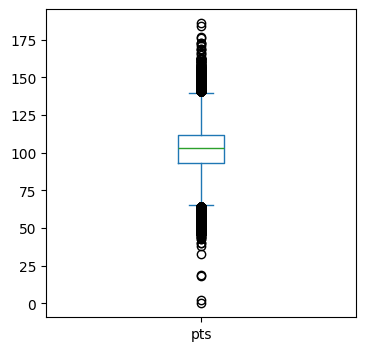

Median: 103.0
IQR: 19.0
75th: 112.0 | top_whisker: 140   | top_threshold: 140.5
25th: 93.0  | bottom_whisker: 65 | bottom_threshold: 64.5


In [20]:
print(df["pts"].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# Boxplot
ax = pts.plot.box(figsize=(4,4))
plt.show()
q75 = df["pts"].quantile(0.75)
q25 = df["pts"].quantile(0.25)
iqr = q75 - q25
q75_threshold = q75 + iqr * 1.5
q25_threshold = q25 - iqr * 1.5
q75_closest = df.loc[df["pts"].le(q75_threshold), "pts"].max()
q25_closest = df.loc[df["pts"].ge(q25_threshold), "pts"].min()
print("Median:",pts.median())
print("IQR:", iqr)
print(f"75th: {q75} | top_whisker: {q75_closest}   | top_threshold: {q75_threshold}")
print(f"25th: {q25}  | bottom_whisker: {q25_closest} | bottom_threshold: {q25_threshold}")

In [19]:
# historgram data
pts_bins = pd.cut(df["pts"], 10)
pts_bins.value_counts()

pts
(93.0, 111.6]     59463
(111.6, 130.2]    30107
(74.4, 93.0]      29112
(130.2, 148.8]     3695
(55.8, 74.4]       3531
(148.8, 167.4]      211
(37.2, 55.8]        179
(167.4, 186.0]       11
(-0.186, 18.6]        3
(18.6, 37.2]          2
Name: count, dtype: int64

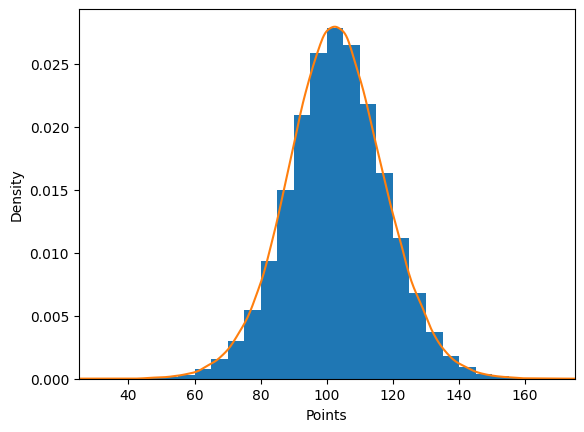

In [33]:
# histogram plot with density plot
ax = df["pts"].plot.hist(density=True, xlim=[25, 175], bins=range(25,175, 5))
df["pts"].plot.density(ax=ax)
ax.set_xlabel("Points")
plt.show()

### Exploring Binary and Categorical Data

- Mode - The most commonly occurring category or value in a data set.
- Expected Value - Average value based on a numeric category's probability of occurrence.
- Bar charts - Frequency or proportion for each category

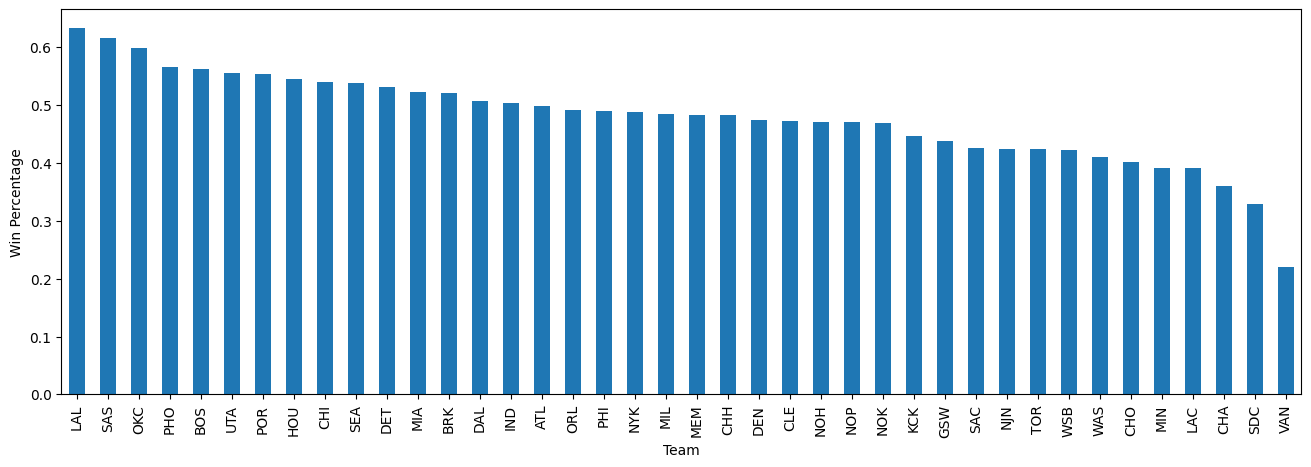

In [52]:
# bar chart of team win percentage since 1980
pivot = (
    df.loc[df["year_id"] > 1980]
      .assign(win=(df["game_result"] == "W").astype(int))  # 1 if win else 0
      .groupby("team_id", as_index=False, observed=True)
      .agg(wins=("win", "sum"), total=("win", "count")) # aggregate wins and total games
      .assign(win_pct=lambda x: x["wins"] / x["total"]) # calc win percentage
      .pivot_table(index=None, columns="team_id", values="win_pct", fill_value=0, observed=True)
)
ax = pivot.transpose().sort_values("win_pct", ascending=False).plot.bar(figsize=(16, 5), legend=False)
ax.set_xlabel("Team")
ax.set_ylabel("Win Percentage")
plt.show()

### Correlation

- Correlation coefficient - A metric that measures the extent to which numeric variables are associated with each other.
  - Pearson's correlation coefficient is the most used standardized correlation coefficient.
  - x's deviation from the mean * y's deviation from the mean / ((n-1) * x and y's standard deviations multiplied together)
  - Pearson's correlation coefficient = $\frac{\sum_{i=1}^{n} (x_i - \bar{x}) (y_i - \bar{y})}{(n-1)s_x s_y}$
- Correlation matrix - A table showing the correlations between variables
- Scatterplot

In [62]:
# SPY and DIA are highly correlated
sp500_sym = pd.read_csv("data/sp500_sectors.csv")
sp500_px = pd.read_csv("data/sp500_data.csv.gz", index_col=0)
etfs = sp500_px.loc[sp500_px.index > '2012-07-01', 
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
corr = etfs.corr()
corr

,XLI,QQQ,SPY,DIA,GLD,VXX,USO,IWM,XLE,XLY,XLU,XLB,XTL,XLV,XLP,XLF,XLK
XLI,1.00,0.79,0.89,0.87,0.06,-0.47,0.24,0.78,0.65,0.80,0.38,0.78,0.37,0.66,0.60,0.79,0.78
QQQ,0.79,1.00,0.91,0.83,0.04,-0.47,0.20,0.81,0.56,0.84,0.35,0.71,0.42,0.78,0.61,0.75,0.95
SPY,0.89,0.91,1.00,0.95,0.08,-0.55,0.27,0.83,0.71,0.89,0.48,0.83,0.41,0.81,0.74,0.88,0.89
DIA,0.87,0.83,0.95,1.00,0.05,-0.51,0.26,0.76,0.66,0.85,0.46,0.79,0.38,0.77,0.75,0.86,0.84
GLD,0.06,0.04,0.08,0.05,1.00,-0.11,0.22,0.07,0.19,0.02,0.12,0.18,-0.04,-0.01,0.03,0.04,0.05
VXX,-0.47,-0.47,-0.55,-0.51,-0.11,1.00,-0.20,-0.45,-0.45,-0.47,-0.26,-0.47,-0.21,-0.38,-0.42,-0.51,-0.48
USO,0.24,0.20,0.27,0.26,0.22,-0.20,1.00,0.25,0.53,0.18,0.11,0.32,0.08,0.12,0.12,0.22,0.23
IWM,0.78,0.81,0.83,0.76,0.07,-0.45,0.25,1.00,0.59,0.78,0.33,0.70,0.39,0.66,0.54,0.76,0.76
XLE,0.65,0.56,0.71,0.66,0.19,-0.45,0.53,0.59,1.00,0.58,0.34,0.69,0.26,0.45,0.41,0.60,0.56
XLY,0.80,0.84,0.89,0.85,0.02,-0.47,0.18,0.78,0.58,1.00,0.37,0.72,0.37,0.70,0.66,0.78,0.77


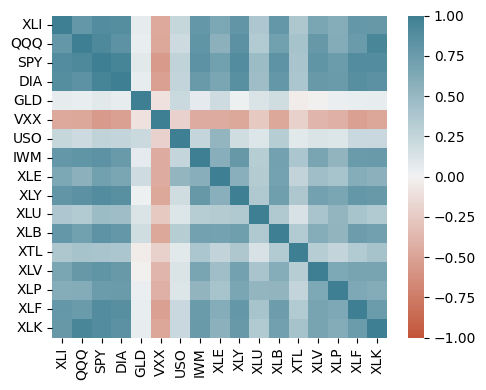

In [70]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), ax=ax)
plt.tight_layout()
plt.show()

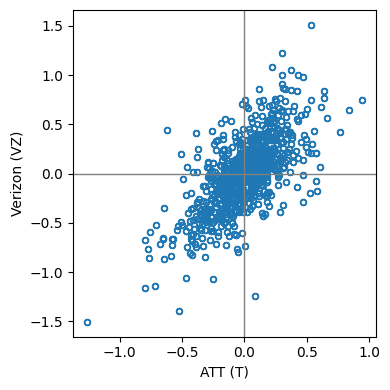

In [71]:
# high correlation visualized in a scatterplot
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()